In [8]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [16]:
pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 20.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [timm]3/4 [timm]ngface_hub]
Note: you may need to restart the kernel to use updated packages.


In [25]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

model = timm.create_model('vit_small_patch16_224.dino', pretrained=True)  # ViT-S/16 DINO
model.reset_classifier(0)              # remove classifier -> embeddings
model.eval().to(device)



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [22]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [26]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config) # preprocessing for this checkpoint

In [27]:
# Prep transforms + load CIFAR-10 (cats=3, dogs=5)

from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# Transform that matches the pretrained DINO checkpoint
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# CIFAR-10
trainset_full = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
testset_full  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Keep only cats (3) & dogs (5)
train_idx = [i for i, y in enumerate(trainset_full.targets) if y in (3, 5)]
test_idx  = [i for i, y in enumerate(testset_full.targets)  if y in (3, 5)]

trainset = Subset(trainset_full, train_idx)
testset  = Subset(testset_full,  test_idx)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True,  num_workers=2)
testloader  = DataLoader(testset,  batch_size=64, shuffle=False, num_workers=2)


In [ ]:
# Extract DINO embeddings (one vector per image)
import torch
import numpy as np


def extract_embeddings(dataloader, model, device):
    X, y = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)

            feats = model.forward_features(imgs)                 # may be [B, N, D] or [B, D]
            emb  = model.forward_head(feats, pre_logits=True)    # -> [B, D] guaranteed

            X.append(emb.cpu().numpy())
            y.append(labels.numpy())

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    y = (y == 5).astype(np.int64)   # cat=0, dog=1
    return X, y


# MPS version - may not work on all Macs
# def extract_embeddings(dataloader, model, device):
#     X, y = [], []
#     with torch.no_grad():
#         for imgs, labels in dataloader:
#             imgs = imgs.to(device, dtype=torch.float32)   # move images to GPU/CPU
#             feats = model.forward_features(imgs)          # forward pass
#             feats = feats.to("cpu").numpy()               # back to CPU numpy
#             X.append(feats)
#             y.append(labels.numpy())                      # labels are already CPU
#     return np.concatenate(X), np.concatenate(y)


X_train, y_train = extract_embeddings(trainloader, model, device)
X_test,  y_test  = extract_embeddings(testloader,  model, device)

print("Train embeddings:", X_train.shape)
print("Test  embeddings:", X_test.shape)


Train embeddings: (10000, 384)
Test  embeddings: (2000, 384)


In [32]:
# Train a simple classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred, target_names=["cat","dog"]))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.942

              precision    recall  f1-score   support

         cat       0.95      0.94      0.94      1000
         dog       0.94      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion matrix:
 [[937  63]
 [ 53 947]]


Matplotlib is building the font cache; this may take a moment.


Explained variance by PC1+PC2: 0.13958083


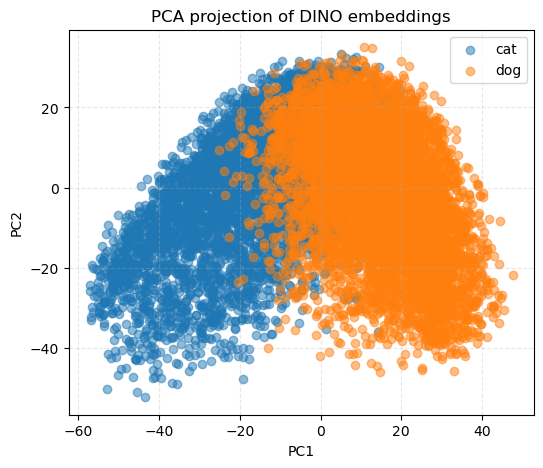

In [ ]:
# PCA visualization of embeddings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Stack train+test just for visualization (keeps labels to color points)
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])   # 0=cat, 1=dog

# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_all)

print("Explained variance by PC1+PC2:", pca.explained_variance_ratio_.sum())

# Plot
plt.figure(figsize=(6,5))
plt.scatter(X_pca[y_all==0, 0], X_pca[y_all==0, 1], alpha=0.5, label="cat")
plt.scatter(X_pca[y_all==1, 0], X_pca[y_all==1, 1], alpha=0.5, label="dog")
plt.title("PCA projection of DINO embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


/Users/sumachinta/miniforge3/envs/dino/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


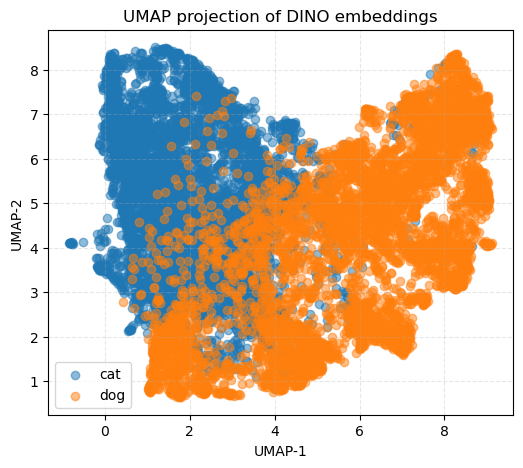

In [34]:
# UMAP visualization of embeddings
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_reducer.fit_transform(X_all)

plt.figure(figsize=(6,5))
plt.scatter(X_umap[y_all==0, 0], X_umap[y_all==0, 1], alpha=0.5, label="cat")
plt.scatter(X_umap[y_all==1, 0], X_umap[y_all==1, 1], alpha=0.5, label="dog")
plt.title("UMAP projection of DINO embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [35]:
# Keep only dog samples (y==1 means dog) to see what are the different clusters in the dog embeddingins in UMAP space
X_dog = X_all[y_all == 1]
dog_indices = np.where(y_all == 1)[0]   # indices back into dataset
print("Dog embeddings shape:", X_dog.shape)


Dog embeddings shape: (6000, 384)


In [36]:
# Clustering dog embeddings with KMeans
from sklearn.cluster import KMeans

n_clusters = 5   # tweak this number based on how many blobs you saw
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dog_clusters = kmeans.fit_predict(X_dog)

print("Cluster counts:", np.bincount(dog_clusters))


Cluster counts: [ 777 1336 1278  927 1682]


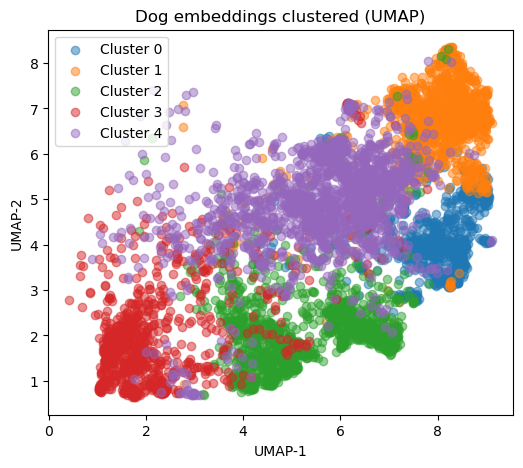

In [37]:
# Visualize dog clusters in UMAP space
plt.figure(figsize=(6,5))
for c in range(n_clusters):
    plt.scatter(X_umap[dog_indices][dog_clusters==c,0],
                X_umap[dog_indices][dog_clusters==c,1],
                label=f"Cluster {c}", alpha=0.5)
plt.title("Dog embeddings clustered (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()


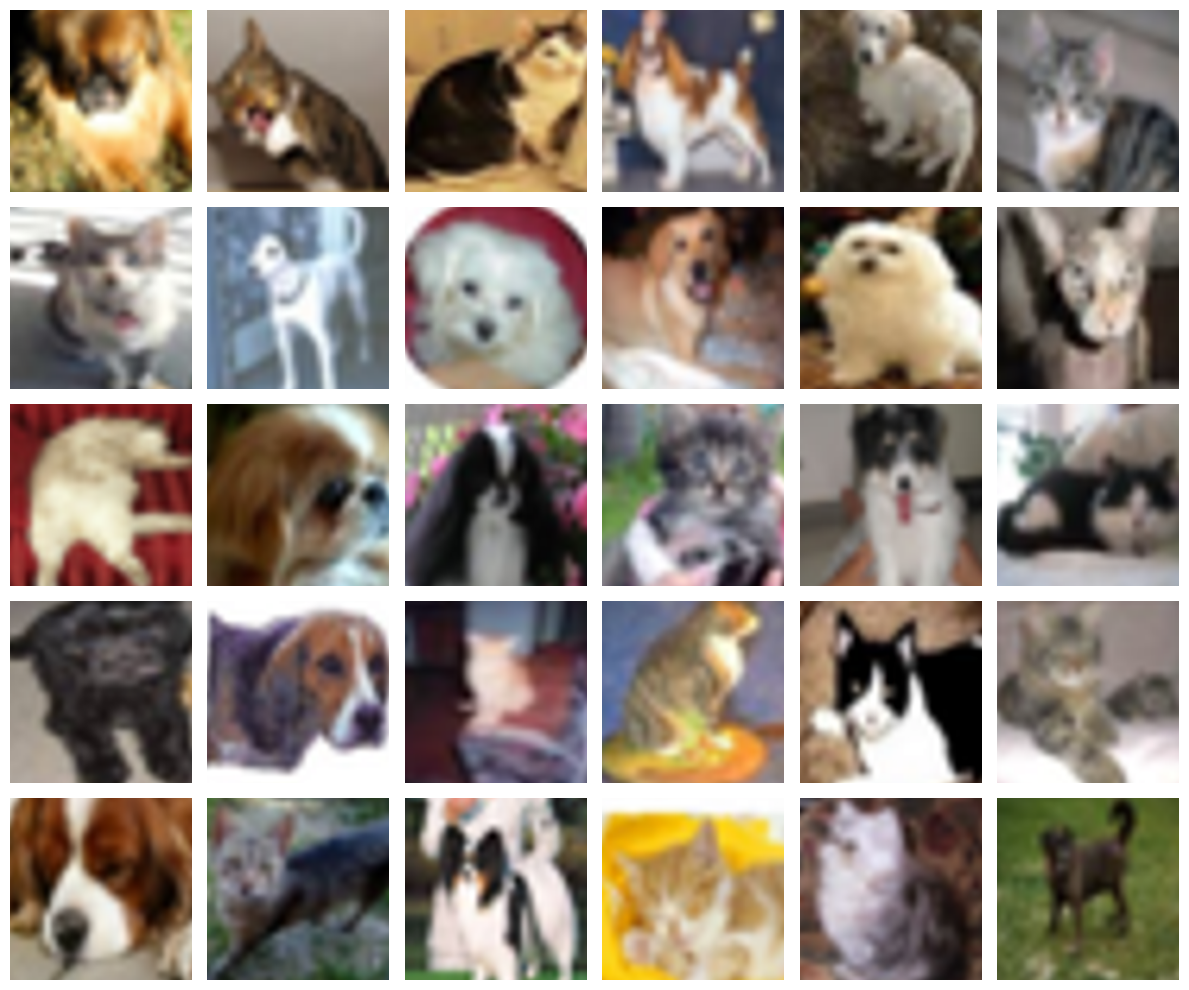

In [43]:
# mean/std from your timm config
mean = config.get('mean', (0.485, 0.456, 0.406))
std  = config.get('std',  (0.229, 0.224, 0.225))

# Only dogs (y_all == 1) – indices are in X_all order (train-subset first, then test-subset)
X_dog = X_all[y_all == 1]
dog_indices = np.where(y_all == 1)[0]

from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dog_clusters = kmeans.fit_predict(X_dog)

# IMPORTANT: pass the *subsets* you actually embedded
show_cluster_examples_from_subsets(trainset, testset,
                                   dog_indices, dog_clusters,
                                   n_samples=6, mean=mean, std=std)


In [44]:
import numpy as np
import matplotlib.pyplot as plt

# de-normalize helper (uses the same mean/std from your TIMM config)
def to_img_display(t, mean, std):
    t = t.detach().cpu()
    for c in range(3):
        t[c] = t[c] * std[c] + mean[c]
    return t.clamp(0, 1).permute(1, 2, 0).numpy()  # CHW -> HWC

def show_cluster_examples_from_subsets(train_subset, test_subset, global_indices, clusters,
                                       n_samples=6, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    """
    global_indices: indices into X_all (which = [train_subset; test_subset])
    clusters: cluster id per entry of X_dog (same length as global_indices subset)
    """
    n_clusters = int(clusters.max()) + 1
    n_train_sub = len(train_subset)

    fig, axs = plt.subplots(n_clusters, n_samples, figsize=(n_samples*2, n_clusters*2))
    if n_clusters == 1:
        axs = np.expand_dims(axs, 0)

    for c in range(n_clusters):
        pool = np.where(clusters == c)[0]
        if len(pool) == 0:
            for j in range(n_samples): axs[c, j].axis("off")
            axs[c, 0].set_ylabel(f"Cluster {c}")
            continue

        replace = len(pool) < n_samples
        chosen = np.random.choice(pool, size=n_samples, replace=replace)

        for j, p in enumerate(chosen):
            gidx = int(global_indices[p])  # index into X_all (train-subset first, then test-subset)
            if gidx < n_train_sub:
                img, _ = train_subset[gidx]
            else:
                img, _ = test_subset[gidx - n_train_sub]

            vis = to_img_display(img, mean, std)
            axs[c, j].imshow(vis); axs[c, j].axis("off")

        axs[c, 0].set_ylabel(f"Cluster {c}")

    plt.tight_layout(); plt.show()
